# About

Here we prepare, plot (and save) the results for CI plots, which were obtained in:
- `colab_extended_ci_rf_and_gp_saving_results.ipnb`

The notebook includes both one-run and multiple-runs CIs plots

In [1]:
%ls

all_plots.ipynb
colab_extended_GPflow_pipeline.ipynb
colab_extended_ci_rf_and_gp_saving_results.ipynb
colab_extended_grid_search_pipeline.ipynb
colab_reproducing_ci_gp.ipynb
colab_reproducing_ci_rf.ipynb
colab_reproducing_grid_search_pipeline.ipynb
eda.ipynb
prepare_and_plot_extended_ci_rf_and_gp_results.ipynb
prepare_extended_grid_search_results.ipynb
prepare_reproducing_grid_search_results.ipynb


In [2]:
%ls ../data/

ESOL_README
FreeSolv_README
Lipo_README
esol_original.csv
esol_original_1024ecfp4_features.csv
esol_original_1024ecfp6_features.csv
esol_original_2048ecfp4_features.csv
esol_original_2048ecfp6_features.csv
esol_original_IdSmilesLabels.csv
esol_original_extra_features.csv
esol_original_rdkit_features.csv
freesolv_original.csv
freesolv_original_1024ecfp4_features.csv
freesolv_original_1024ecfp6_features.csv
freesolv_original_2048ecfp4_features.csv
freesolv_original_2048ecfp6_features.csv
freesolv_original_IdSmilesLabels.csv
freesolv_original_rdkit_features.csv
lipophilicity_original.csv
lipophilicity_original_1024ecfp4_features.csv
lipophilicity_original_1024ecfp6_features.csv
lipophilicity_original_2048ecfp4_features.csv
lipophilicity_original_2048ecfp6_features.csv
lipophilicity_original_IdSmilesLabels.csv
lipophilicity_original_rdkit_features.csv


## Import modules

### Standard imports

In [3]:
import json
import pickle

import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# metrics
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import jaccard_score # Tanimoto

### Custom imports

In [5]:
sys.path.insert(0, '..')

# plotting
from util_scripts.plotting_functions_and_vars import FIGSIZE_CI, FIGSIZE_HEATMAP, DPI, PLOTS_DIR
from util_scripts.plotting_functions_and_vars import datasets_to_titles, datasets_to_units, metrics_to_labels
from util_scripts.plotting_functions_and_vars import plot_algorithm_dataset_comparison_heatmap


from util_scripts.plotting_functions_and_vars import datasets_to_rounding_precision

sys.path.insert(0, './notebooks')

## Set plotting style

In [6]:
%matplotlib inline
plt.style.use('fivethirtyeight')

plt.rcParams['axes.facecolor']='w'
#plt.rcParams['axes.linewidth']=1
plt.rcParams['axes.edgecolor']='w'
plt.rcParams['figure.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
#plt.rcParams['grid.color']='white'

# sns.set()

# Load Data

## CHOOSE: dataset, smile_type, grid_search_type

In [7]:
dataset = 'freesolv'
assert dataset in ['freesolv', 'esol', 'lipophilicity']

smile_type = 'original'
assert smile_type in ['original', 'protonated']

grid_search_type = 'extended'
assert grid_search_type in ['reproducing', 'extended']

# correlated features treatment
if dataset == 'esol':
    cf = 'reduced'
else:
    cf = 'full'
assert cf in ['reduced', 'full']

In [8]:
# # for esol
# cf = 'full'

## Titles, Units and Labels for datasets

In [9]:
for key, value in datasets_to_titles.items():
    print(key, (13 - len(key))*' ' + ': ',  value)

freesolv      :  Solvation Energy
esol          :  Log Solubility
lipophilicity :  Octanol/Water Distribution Coefficient


In [10]:
for key, value in datasets_to_units.items():
    print(key, (13 - len(key))*' ' + ': ',  value)

freesolv      :  (kcal/mol)
esol          :  (mol/litre)
lipophilicity :  (logD)


In [11]:
for key, value in metrics_to_labels.items():
    print(key, (13 - len(key))*' ' + ': ',  value)

RMSE          :  root-mean-square error
MAE           :  mean absolute error
R^2           :  R^2 (coefficient of determination)
pearson_r     :  Pearson correlation


In [12]:
rp = datasets_to_rounding_precision[dataset]
rp

2

## CHOOSE metric to display

In [13]:
metric = 'RMSE'
assert metric in metrics_to_labels

In [14]:
if metric in ['RMSE', 'MAE']:
    pass
else:
    # no units
    datasets_to_units = {'freesolv': '', 'esol': '', 'lipophilicity': ''}

## Choose model to show

In [15]:
model = 'gp'
assert model in ['rf', 'gp']

In [16]:
models_to_title_additions = {
    'rf': 'Random Forests',
    'gp': 'Gaussian Processes'
}

## Load files:

In [17]:
print(dataset, smile_type, grid_search_type, cf, model)

freesolv original extended full gp


In [18]:
# save results as csv-s, rewrite each time
df_true = pd.read_csv(f'../results/{dataset}_{smile_type}_{grid_search_type}_{cf}_multiple_ci_runs_true_{model}.csv')
df_pred = pd.read_csv(f'../results/{dataset}_{smile_type}_{grid_search_type}_{cf}_multiple_ci_runs_pred_{model}.csv')
df_std = pd.read_csv(f'../results/{dataset}_{smile_type}_{grid_search_type}_{cf}_multiple_ci_runs_std_{model}.csv')

## Have a look at files

In [19]:
df_true.shape, df_pred.shape, df_std.shape

((129, 50), (129, 50), (129, 50))

In [20]:
df_true.head()

,test_true_0,test_true_1,test_true_2,test_true_3,test_true_4,test_true_5,test_true_6,test_true_7,test_true_8,test_true_9,...,test_true_40,test_true_41,test_true_42,test_true_43,test_true_44,test_true_45,test_true_46,test_true_47,test_true_48,test_true_49
0,-0.03,-4.52,-1.69,-4.39,-0.53,-0.56,-2.46,-1.89,-5.23,-4.42,...,2.83,2.67,0.06,-5.91,-3.28,-7.62,-3.18,1.47,-3.84,1.79
1,-4.05,-2.87,-0.53,-1.82,-5.00,-5.90,-1.12,2.51,1.47,-2.47,...,-6.32,-0.83,-7.50,-1.69,-3.13,-4.95,-2.01,-4.84,-5.73,1.28
2,-9.44,-3.90,-1.40,-6.27,-3.84,-0.74,-2.49,-3.47,-4.85,-3.50,...,-2.98,1.20,-3.20,-7.67,-3.15,0.68,-2.29,-12.64,-8.72,-18.06
3,-7.50,-5.21,-1.59,-11.00,-0.48,-9.52,-6.68,1.28,-4.29,-5.31,...,-1.21,-4.82,-2.33,-4.53,-0.55,-4.47,-3.93,-4.42,-2.69,-0.89
4,-8.18,-6.50,-7.81,1.68,0.00,-2.51,-8.68,-10.64,-1.66,-0.50,...,-6.21,-0.99,-2.93,-2.68,2.30,-1.82,-6.13,-3.64,-4.15,-5.10


In [21]:
df_pred.head()

,test_pred_0,test_pred_1,test_pred_2,test_pred_3,test_pred_4,test_pred_5,test_pred_6,test_pred_7,test_pred_8,test_pred_9,...,test_pred_40,test_pred_41,test_pred_42,test_pred_43,test_pred_44,test_pred_45,test_pred_46,test_pred_47,test_pred_48,test_pred_49
0,0.174816,-5.403831,-3.274425,-4.447411,-1.846489,-0.546595,-4.089564,-2.022408,-5.768080,-2.475796,...,2.440376,2.410588,-0.311939,-3.673487,-2.571871,-6.639187,-1.885288,1.219015,-6.105247,1.133009
1,-3.743958,-3.328251,-0.271619,-3.107580,-4.166100,-5.361467,-0.346390,1.893359,0.740196,-1.795530,...,-4.050192,-0.429519,-4.080853,-4.236274,-3.756021,-6.579486,-0.122997,-3.179209,-4.104178,0.198455
2,-10.726209,-3.765307,-1.267958,-7.575893,-3.068241,-1.074859,-2.538935,-3.737324,-4.826698,-1.790208,...,-1.637594,1.059082,-1.992944,-6.733774,-4.138683,-0.037156,-2.526144,-14.235517,-9.481966,-15.705239
3,-7.054958,-5.047950,-1.147879,-10.839027,1.057673,-7.943922,-6.857159,0.206372,-4.390170,-3.831757,...,-0.385784,-5.348847,-2.449308,-4.972000,-0.556345,-6.131433,-1.784000,-4.501955,-2.282036,-0.437214
4,-7.092776,-6.370045,-5.658118,1.093127,0.269584,-2.025778,-8.644570,-7.122867,-3.558174,-0.452816,...,-6.119804,0.988873,-2.659484,-2.552903,1.612713,-3.918633,-5.310879,-3.438615,-4.170983,-5.647818


In [22]:
df_std.head()

,test_std_0,test_std_1,test_std_2,test_std_3,test_std_4,test_std_5,test_std_6,test_std_7,test_std_8,test_std_9,...,test_std_40,test_std_41,test_std_42,test_std_43,test_std_44,test_std_45,test_std_46,test_std_47,test_std_48,test_std_49
0,23.490245,23.874348,24.915664,12.771688,18.267416,20.625136,21.591944,20.721950,38.812480,9.231467,...,11.855182,11.532729,11.988138,21.241444,24.531445,15.191000,21.960206,13.754753,32.233577,13.219696
1,33.398020,25.708480,15.346810,25.845509,7.410208,12.002490,25.663365,3.994287,13.987655,31.559505,...,25.762281,9.041655,29.206643,23.079248,19.292146,34.131981,13.458933,8.838059,18.452234,10.323678
2,30.592278,16.272562,22.316483,21.293083,13.095352,6.110981,0.208721,5.524523,10.985678,14.170701,...,29.226647,0.478647,37.492867,24.682893,19.509562,28.990427,0.294612,46.758351,21.400474,24.553200
3,18.230849,20.125504,11.761404,14.574425,18.263340,19.171845,33.608416,7.069977,17.188767,22.277082,...,17.457621,27.087299,8.300775,15.504241,4.108862,62.748309,20.738159,13.684764,26.528539,9.475698
4,25.814773,14.967797,13.167430,20.837159,10.227491,15.263964,25.395142,17.234353,12.628289,13.931273,...,16.453644,20.562656,14.136812,10.127047,5.415311,22.964565,14.921818,11.272029,14.464209,14.783929


# One run

In [23]:
y_test = df_true.iloc[:, 0]
y_test_pred = df_pred.iloc[:, 0]
y_test_std = df_std.iloc[:, 0]

## RMSE

In [24]:
mean_squared_error(y_true=y_test, y_pred=y_test_pred, squared=False)

1.219765931245066

## Calculate confidence bounds using std part of gpr predictions

In [25]:
upper = y_test_pred + 1.96 * y_test_std
lower = y_test_pred - 1.96 * y_test_std

In [26]:
CIs_df = pd.DataFrame(
    {'y_test': y_test,
     'y_test_pred': y_test_pred,
     'y_test_std': y_test_std,
     'lower': lower,
     'upper': upper,
     'sq_error': (y_test - y_test_pred) ** 2
     }
)
CIs_df = CIs_df.sort_values(by='y_test_std', ascending=True)
CIs_df['cumul_sq_error'] = CIs_df['sq_error'].cumsum()
CIs_df['cumul_mse'] = CIs_df['cumul_sq_error'].values / np.arange(1, CIs_df.shape[0]+1)
CIs_df['cumul_rmse'] = np.sqrt(CIs_df['cumul_mse'])
display(CIs_df)

,y_test,y_test_pred,y_test_std,lower,upper,sq_error,cumul_sq_error,cumul_mse,cumul_rmse
69,-4.20,-4.159811,0.216285,-4.583730,-3.735892,0.001615,0.001615,0.001615,0.040189
115,-3.65,-3.629590,0.254270,-4.127959,-3.131221,0.000417,0.002032,0.001016,0.031873
75,3.13,2.957805,0.260494,2.447236,3.468374,0.029651,0.031683,0.010561,0.102766
91,2.06,2.331481,0.299360,1.744736,2.918226,0.073702,0.105385,0.026346,0.162315
103,2.88,2.817241,0.341000,2.148881,3.485601,0.003939,0.109323,0.021865,0.147867
...,...,...,...,...,...,...,...,...,...
12,-11.53,-12.024339,37.426500,-85.380279,61.331600,0.244371,169.094865,1.352759,1.163082
95,-4.51,-5.677993,38.892840,-81.907959,70.551973,1.364208,170.459073,1.352850,1.163121
89,-2.53,-6.731118,39.149817,-83.464759,70.002523,17.649390,188.108463,1.481169,1.217033
55,-9.01,-8.939368,41.290223,-89.868204,71.989469,0.004989,188.113452,1.469636,1.212286


In [27]:
# checking that calculating rmse each time separately would be the same
CIs_df = CIs_df.sort_values(by='y_test_std', ascending=True)


calculation_match = []
for i in range(CIs_df.shape[0]):
    a = CIs_df.y_test[:i+1]
    b = CIs_df.y_test_pred[:i+1]
    
    calculation_match.append(np.abs(mean_squared_error(a, b, squared=False) - CIs_df.cumul_rmse.iloc[i]) < 1e-8)
    
# if returns true - it is the same
assert np.all(calculation_match) 

## Plot test observations with sdt values as colours

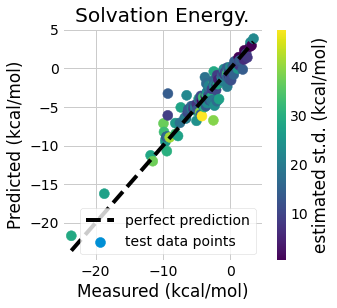

In [28]:
# sort values used for x axis
CIs_df = CIs_df.sort_values(by='y_test')

# Plot error bars for predicted quantity using unbiased variance
plt.figure(figsize=FIGSIZE_CI)

plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'k--', label='perfect prediction')
plt.scatter(x=CIs_df.y_test, y=CIs_df.y_test_pred, c=CIs_df.y_test_std, s=100, label='test data points')

plt.xlabel(f'Measured {datasets_to_units[dataset]}')
plt.ylabel(f'Predicted {datasets_to_units[dataset]}')
plt.title(f'{datasets_to_titles[dataset]}.')

# add colourbar and legend
plt.colorbar(label=f'estimated st.d. {datasets_to_units[dataset]}')
plt.legend()

plt.savefig(f'{PLOTS_DIR}/ci_plots/predicted_vs_measured_scatter_colour_conf_{dataset}_{cf}_{model}.png', dpi=DPI, bbox_inches='tight')
plt.show()

## Plot sq^error vs std

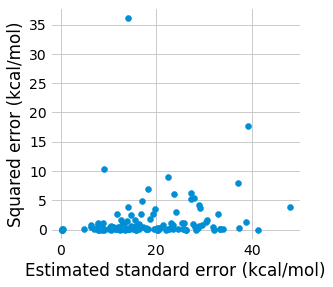

In [29]:
# sort values used for x axis
CIs_df = CIs_df.sort_values(by='y_test_std')

# Plot error bars for predicted quantity using unbiased variance
plt.figure(figsize=FIGSIZE_CI)

#plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'k--', label='perfect prediction')
plt.scatter(x=CIs_df.y_test_std, y=CIs_df.sq_error)


plt.xlabel(f'Estimated standard error {datasets_to_units[dataset]}')
plt.ylabel(f'Squared error {datasets_to_units[dataset]}')
# plt.title(f'{datasets_to_titles[dataset]}')

# # add colourbar and legend
# plt.colorbar()
# plt.legend()

#plt.savefig(f'{PLOTS_DIR}/pubs_units_values.png', bbox_inches='tight')
plt.show()

## Plot 95% confidence intervals

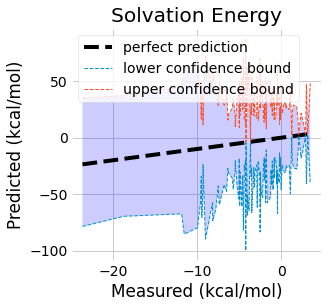

In [30]:
# sort values used for x axis
CIs_df = CIs_df.sort_values(by='y_test')

fig, ax = plt.subplots(1, figsize=FIGSIZE_CI)

# ax.set_aspect('equal')

ax.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'k--', label='perfect prediction')

ax.plot(CIs_df.y_test, CIs_df.lower, linewidth=1, linestyle='--', label='lower confidence bound')
ax.plot(CIs_df.y_test, CIs_df.upper, linewidth=1, linestyle='--', label='upper confidence bound')
ax.fill_between(CIs_df.y_test, CIs_df.upper, CIs_df.lower, facecolor='blue', alpha=0.2)




ax.set_title(f'{datasets_to_titles[dataset]}')
ax.set_xlabel(f'Measured {datasets_to_units[dataset]}')
ax.set_ylabel(f'Predicted {datasets_to_units[dataset]}')

ax.legend(loc='upper left')

#plt.savefig(f'{PLOTS_DIR}/ci_plots/predicted_vs_measured_with_ci_bounds_{dataset}_{cf}_{model}.png', dpi=DPI, bbox_inches='tight')
plt.show()

## Calculate the proportion of measured values in test set within 95% CIs

In [31]:
within_cis = (CIs_df.lower <= CIs_df.y_test) & (CIs_df.y_test <= CIs_df.upper)
within_cis.sum() / len(within_cis)

1.0

## Confidence plots (RMSE vs Prcentile)

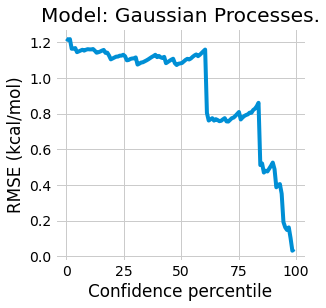

In [32]:
# sort values used for x axis
CIs_df = CIs_df.sort_values(by='y_test_std', ascending=True)

# set size
plt.figure(figsize=FIGSIZE_CI)

confidence_percentiles = np.arange(1e-14, 100, 100/len(y_test))
flipped_cumul_rmse = CIs_df['cumul_rmse'].values[::-1]


plt.plot(confidence_percentiles, flipped_cumul_rmse)
plt.title(f'Model: {models_to_title_additions[model]}.')
plt.xlabel('Confidence percentile')
plt.ylabel(f'RMSE {datasets_to_units[dataset]}')


plt.savefig(f'{PLOTS_DIR}/ci_plots/cumulrmse_vs_confidence_one_run_{dataset}_{cf}_{model}.png', dpi=DPI, bbox_inches='tight')
plt.show()

In [33]:
corr, p_value = pearsonr(confidence_percentiles, flipped_cumul_rmse)
corr, p_value

(-0.8486272634647336, 6.26798884329671e-37)

# Multiple runs

In [34]:
dataset_to_num_cis = {
    'freesolv': 50,
    'esol': 30,
    'lipophilicity': 10
}

In [35]:
dataset_to_num_cis[dataset]

50

In [36]:
rmse_mult_runs = []
within_95_cis_mult_runs = []
cumulrmse_vs_percentile_corr_mult_runs = []

flipped_cumulrmse_mult_runs = []

for i in range(dataset_to_num_cis[dataset]):
    
    # get data
    y_test = df_true.iloc[:, i]
    y_test_pred = df_pred.iloc[:, i]
    y_test_std = df_std.iloc[:, i]
    
    # calculate and record rmse
    rmse_mult_runs.append(mean_squared_error(y_true=y_test, y_pred=y_test_pred, squared=False))
    
    # calculate upper and lower 95% conf bounds
    upper = y_test_pred + 1.96 * y_test_std
    lower = y_test_pred - 1.96 * y_test_std
    
    # calculate and record proportion of true values within 95% CI from prediction
    within_cis = (lower <= y_test) & (y_test <= upper)
    within_cis_proportion = within_cis.sum() / len(within_cis)
    within_95_cis_mult_runs.append(within_cis_proportion)
    
    # create a dataframe to be able to sort things easily
    CIs_df = pd.DataFrame(
        {'y_test': y_test,
         'y_test_pred': y_test_pred,
         'y_test_std': y_test_std,
         'lower': lower,
         'upper': upper,
         'sq_error': (y_test - y_test_pred) ** 2
        }
    )
    
    # create cumulative rmse column
    CIs_df = CIs_df.sort_values(by='y_test_std', ascending=True)
    CIs_df['cumul_sq_error'] = CIs_df['sq_error'].cumsum()
    CIs_df['cumul_mse'] = CIs_df['cumul_sq_error'].values / np.arange(1, CIs_df.shape[0]+1)
    CIs_df['cumul_rmse'] = np.sqrt(CIs_df['cumul_mse'])
    
    # record confidence percentiles and flip cumulative rmses
    confidence_percentiles = np.arange(1e-14, 100, 100/len(y_test))
    flipped_cumul_rmse = CIs_df['cumul_rmse'].values[::-1]
    
    # record flipped cumulative rmse
    flipped_cumulrmse_mult_runs.append(flipped_cumul_rmse)
    
    # record correlation between cumulative rmse and confidence percentile
    cumulrmse_vs_percentile_corr_mult_runs.append(pearsonr(confidence_percentiles, flipped_cumul_rmse)[0])

print('Done')

Done


# Important metrics (corr, rmse, within_95)

In [37]:
dataset, cf, model

('freesolv', 'full', 'gp')

## Correlation

In [38]:
#cumulrmse_vs_percentile_corr_mult_runs

In [39]:
np.mean(cumulrmse_vs_percentile_corr_mult_runs).round(3), np.std(cumulrmse_vs_percentile_corr_mult_runs).round(3)

(-0.898, 0.067)

## RMSE

In [40]:
#rmse_mult_runs

In [41]:
np.mean(rmse_mult_runs).round(3), np.std(rmse_mult_runs).round(3)

(1.417, 0.251)

## Within 95% CIs

In [42]:
#within_95_cis_mult_runs

In [43]:
np.mean(within_95_cis_mult_runs).round(3), np.std(within_95_cis_mult_runs).round(3)

(0.996, 0.005)

# Separate plots (do not save)

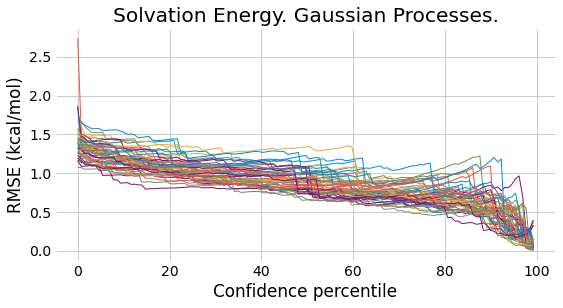

In [44]:
# set size
plt.figure(figsize=FIGSIZE_HEATMAP)

for flipped_cumul_rmse in flipped_cumulrmse_mult_runs:
    plt.plot(confidence_percentiles, flipped_cumul_rmse, linewidth=1)

plt.title(f'{datasets_to_titles[dataset]}. {models_to_title_additions[model]}.')
plt.xlabel('Confidence percentile')
plt.ylabel(f'RMSE {datasets_to_units[dataset]}')


#plt.savefig(f'{PLOTS_DIR}/ci_plots/cumulrmse_vs_confidence_mult_run_{dataset}_{cf}_{model}.png', dpi=DPI, bbox_inches='tight')
plt.show()

# Calculations for Confidence Plot

In [45]:
#print(np.array(flipped_cumulrmse_mult_runs).shape)
#print(np.array(flipped_cumulrmse_mult_runs).std(axis=0).shape)
#print(np.array(flipped_cumulrmse_mult_runs).mean(axis=0).shape)

flipped_cumulrmse_mean = np.array(flipped_cumulrmse_mult_runs).mean(axis=0)
flipped_cumulrmse_sdt = np.array(flipped_cumulrmse_mult_runs).mean(axis=0)

flipped_cumulrmse_lower = flipped_cumulrmse_mean - 1.96*flipped_cumulrmse_sdt
flipped_cumulrmse_upper = flipped_cumulrmse_mean + 1.96*flipped_cumulrmse_sdt

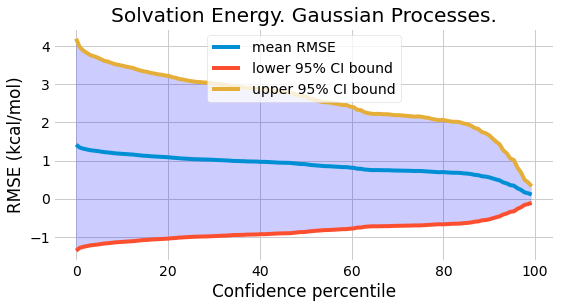

In [46]:
# set size
plt.figure(figsize=FIGSIZE_HEATMAP)

plt.plot(confidence_percentiles, flipped_cumulrmse_mean, label=f'mean {metric}')
plt.plot(confidence_percentiles, flipped_cumulrmse_lower, label=f'lower 95% CI bound')
plt.plot(confidence_percentiles, flipped_cumulrmse_upper, label=f'upper 95% CI bound')
plt.fill_between(confidence_percentiles, flipped_cumulrmse_upper, flipped_cumulrmse_lower, facecolor='blue', alpha=0.2)

plt.legend(loc='upper center')

plt.title(f'{datasets_to_titles[dataset]}. {models_to_title_additions[model]}.')
plt.xlabel('Confidence percentile')
plt.ylabel(f'RMSE {datasets_to_units[dataset]}')

#plt.savefig(f'{PLOTS_DIR}/ci_plots/cumulrmse_vs_confidence_with_ci_bounds_{dataset}_{cf}_{model}.png', dpi=DPI, bbox_inches='tight')
plt.show()

### Together

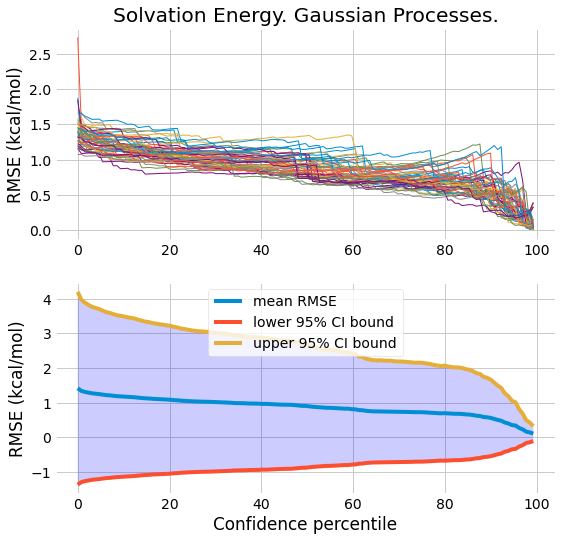

In [47]:
# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8)) #, sharey=True

for flipped_cumul_rmse in flipped_cumulrmse_mult_runs:
    ax1.plot(confidence_percentiles, flipped_cumul_rmse, linewidth=1)

ax1.set_title(f'{datasets_to_titles[dataset]}. {models_to_title_additions[model]}.')
#ax1.set_xlabel('Confidence percentile')
ax1.set_ylabel(f'RMSE {datasets_to_units[dataset]}')


ax2.plot(confidence_percentiles, flipped_cumulrmse_mean, label=f'mean {metric}')
ax2.plot(confidence_percentiles, flipped_cumulrmse_lower, label=f'lower 95% CI bound')
ax2.plot(confidence_percentiles, flipped_cumulrmse_upper, label=f'upper 95% CI bound')
ax2.fill_between(confidence_percentiles, flipped_cumulrmse_upper, flipped_cumulrmse_lower, facecolor='blue', alpha=0.2)

ax2.legend(loc='upper center')

#ax2.set_title(datasets_to_titles[dataset])
ax2.set_xlabel('Confidence percentile')
ax2.set_ylabel(f'RMSE {datasets_to_units[dataset]}')

plt.savefig(f'{PLOTS_DIR}/ci_plots/cumulrmse_vs_confidence_multiple_runs_both_{dataset}_{cf}_{model}.png', dpi=DPI, bbox_inches='tight')
plt.show()